# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Импортируем полезные библиотеки, которые пригодятся нам в будущем

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phik
from time import time
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor

Зададим параметры по умолчанию и объявим константы, которые понадобятся нам в дальнейшем

In [2]:
RANDOM_STATE = 751286
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rc('font', size=SMALL_SIZE)                                    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                              # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                              # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                              # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                            # fontsize of the figure title
plt.rc('figure', figsize=(24, 18))                                 # size of the figure

## Подготовка данных

### Загрузка и разведочный анализ данных

#### Получим данные с информацией о технических характеристиках, комплектации и ценах автомобилей:

In [3]:
datetime_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
# Получим данные безопасным способом при помощи конструкции try-except

try:
    data = pd.read_csv('/datasets/autos.csv', parse_dates=datetime_columns)
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=datetime_columns)

#### Ознакомимся с набором данных. Выведем несколько строк из датафрейма, взятых случайным образом:

In [4]:
data.sample(5, random_state=RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
206905,2016-03-14 18:58:08,1400,sedan,2001,manual,90,civic,150000,3,petrol,honda,no,2016-03-14,0,66130,2016-04-06 03:17:08
231455,2016-03-16 07:53:54,2890,sedan,2002,manual,102,leon,70000,12,petrol,seat,no,2016-03-16,0,42719,2016-03-19 05:15:29
208919,2016-03-16 15:48:53,799,small,1997,manual,54,twingo,150000,10,petrol,renault,no,2016-03-16,0,14163,2016-03-17 13:46:34
232994,2016-03-29 19:41:45,350,coupe,1995,manual,101,NaN,150000,0,NaN,opel,no,2016-03-29,0,95659,2016-04-06 05:17:34
71712,2016-03-25 14:51:07,9999,wagon,2005,auto,272,5er,150000,7,gasoline,bmw,no,2016-03-25,0,40625,2016-04-06 18:18:24


#### Отобразим информацию для краткого обзора данных:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

#### Посчитаем количество пропущенных значений:

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

#### Отобразим таблицу с описательной статистикой признаков:

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.0000,354369.0000,354369.0000,354369.0000,354369.0000,354369.0000,354369.0000
mean,4416.6568,2004.2344,110.0943,128211.1725,5.7146,0.0000,50508.6891
std,4514.1585,90.2280,189.8504,37905.3415,3.7264,0.0000,25783.0962
min,0.0000,1000.0000,0.0000,5000.0000,0.0000,0.0000,1067.0000
25%,1050.0000,1999.0000,69.0000,125000.0000,3.0000,0.0000,30165.0000
50%,2700.0000,2003.0000,105.0000,150000.0000,6.0000,0.0000,49413.0000
75%,6400.0000,2008.0000,143.0000,150000.0000,9.0000,0.0000,71083.0000
max,20000.0000,9999.0000,20000.0000,150000.0000,12.0000,0.0000,99998.0000


#### Отобразим таблицу с попарными корреляциями признаков:

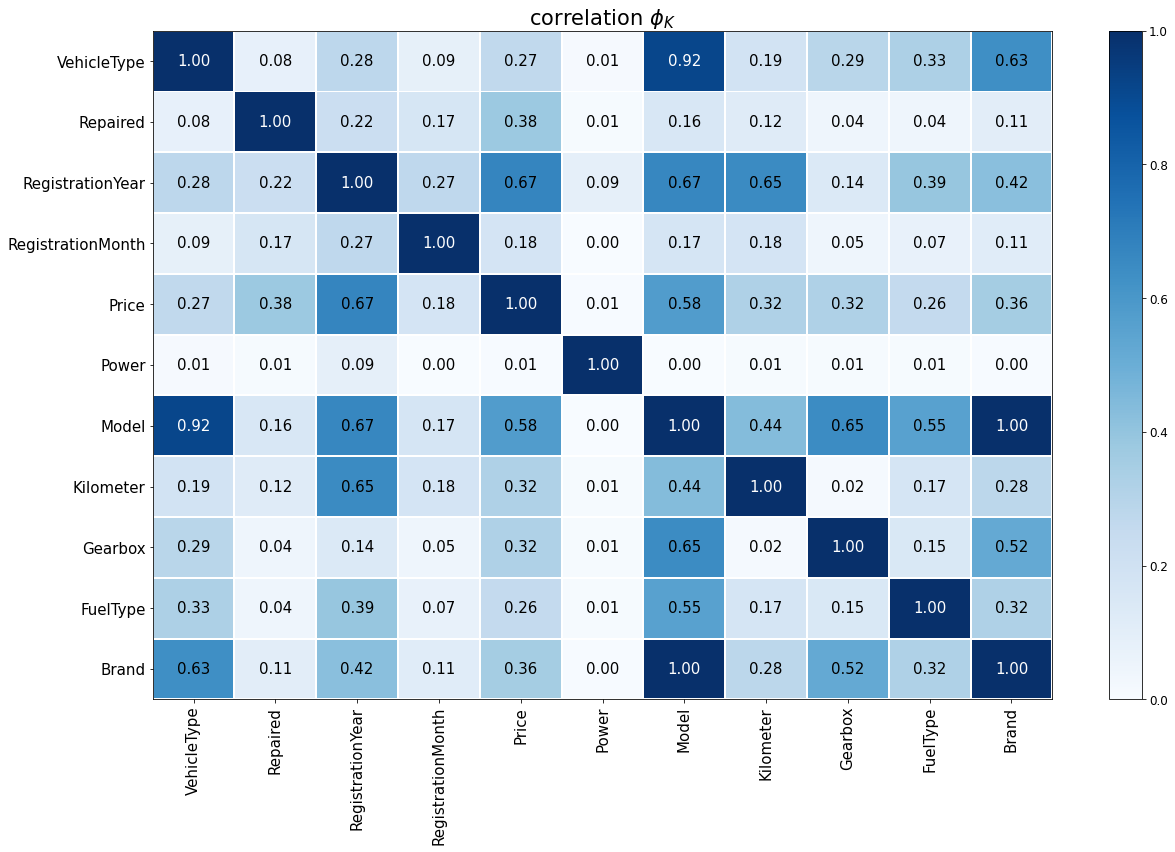

In [8]:
phik_overview = (
    data[data.columns.difference(['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'PostalCode'])]
    .phik_matrix(interval_cols=['Power', 'Price'])
)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(18, 12))
plt.tight_layout()

#### Отобразим гистограммы распределений значений признаков:

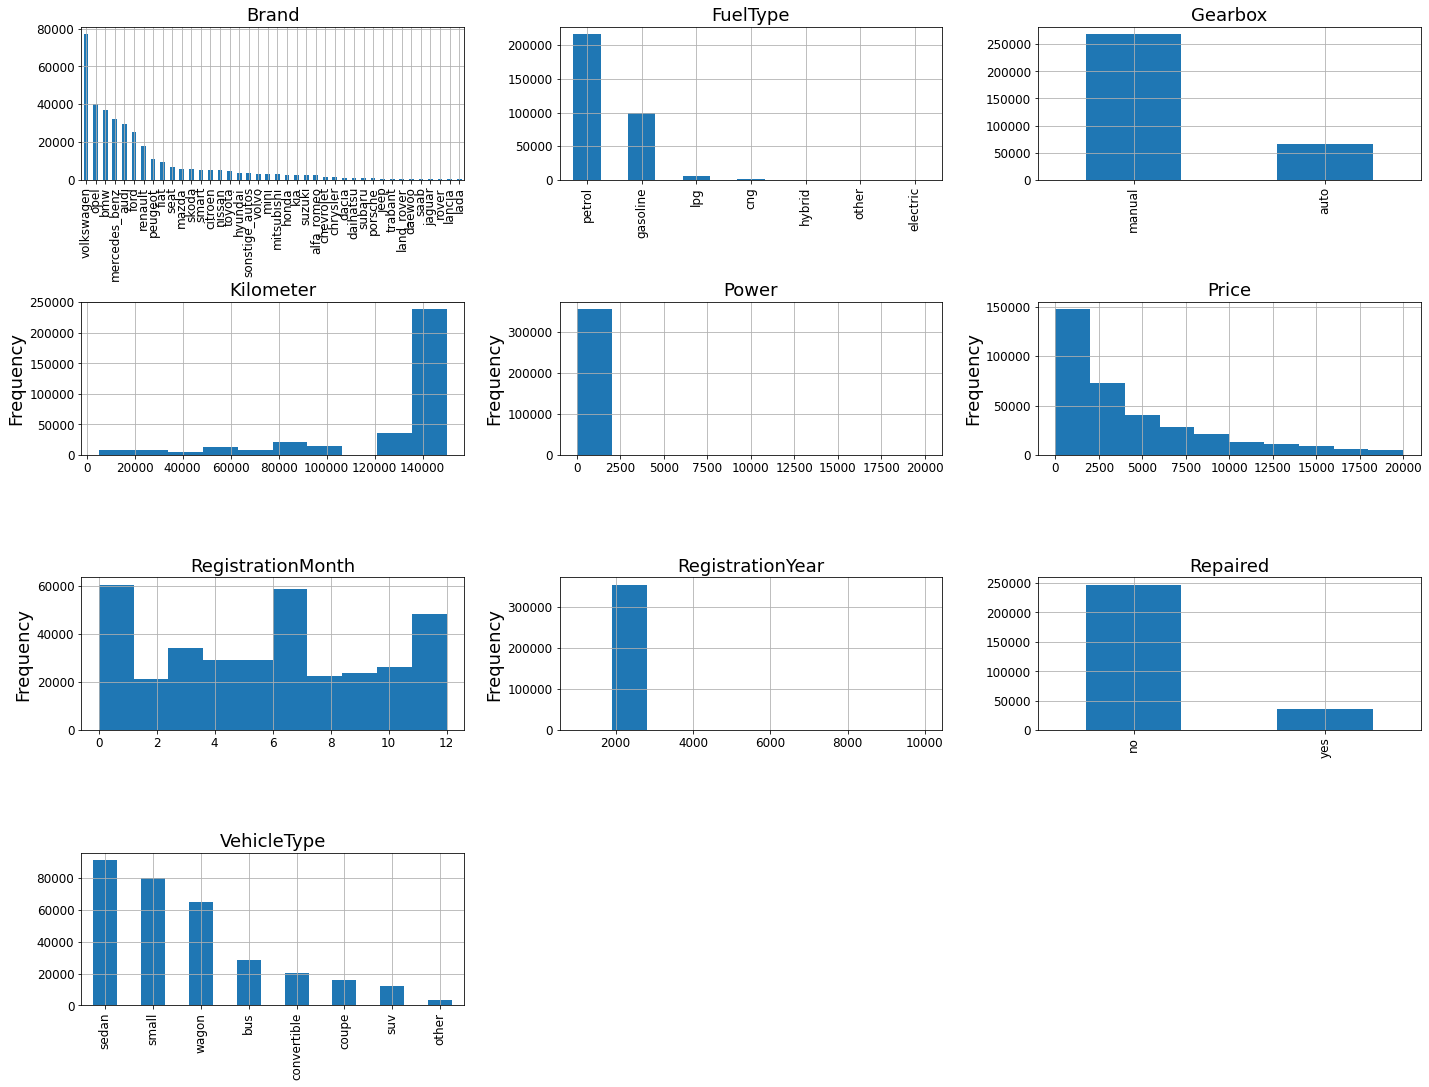

In [9]:
fig = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.8)

for i, col in enumerate(data.columns.difference(['DateCrawled', 'Model', 'DateCreated',
                                                 'NumberOfPictures', 'PostalCode', 'LastSeen'])):
    ax = fig.add_subplot(4, 3, i + 1)
    
    # Отобразим количественные и категориальные переменные соответствующими методами
    if np.issubdtype(data[col].dtype, np.number):
        data[col].plot(kind='hist')
    else:
        data[col].value_counts().plot(kind='bar')
    
    ax.set_title(col)
    ax.grid(visible=True)

#### Краткий вывод:
- в данных присутствуют нарушения правила хорошего стиля в названиях столбцов
- в данных отсутствуют несоответствия типов в столбцах 
- в данных присутствуют явные пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`
- в данных присутствуют неявные пропуски в столбцах `Price` и `NumberOfPictures`, равные $0$
- в данных присутствуют аномальные значения
- в данных присутствуют намёки на мультиколлинеарность
- самый популярный бренд — `volkswagen`
- большинство автомобилей заправляются бензином
- большинство автомобилей имеют механическую коробку передач
- большинство автомобилей никогда не ремонтировались

### Предобработка данных

#### Исправим нарушения правил хорошего стиля в названиях столбцов:

In [10]:
data.rename(inplace=True, columns={
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'repaired',
    'DateCreated': 'date_created',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen'
})

#### Удалим неинформативные признаки, которые не несут ценности для прогноза:

Перед удалением запомним год выгрузки данных. Он понадобится нам при фильтрации аномальных значений в признаке `registration_year`
<a id='date_crawled_year'></a>

In [11]:
# check
data.date_crawled.dt.year.unique()

array([2016])

In [12]:
# check
data.number_of_pictures.unique()

array([0])

- стобец `number_of_pictures` состоит из одних нулей и никак не влияет на рыночную стоимость автомобиля
- столбецы `date_crawled`, `registration_month`, `date_created`, `last_seen`, `postal_code` никак не влияют на рыночную стоимость автомобиля

In [13]:
data.drop(['date_crawled', 'registration_month', 'date_created',
           'last_seen', 'postal_code', 'number_of_pictures'], axis=1, inplace=True)
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

#### Очистим данные от дубликатов

In [14]:
# check
data.duplicated().sum()

45040

В данных были обнаружены только явные дубликаты. Удалим их

In [15]:
data.drop_duplicates(inplace=True)

#### Очистим данные от аномальных значений

In [16]:
# check
for col in data.columns:
    print(col, ': ', data[col].sort_values().unique(), '\n', sep='')

price: [    0     1     2 ... 19998 19999 20000]

vehicle_type: ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

registration_year: [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]

gearbox: ['auto' 'manual' nan]

power: [    0     1     2     3     4     5 

##### Столбец `registration_year`

Cоотношение строк с годом регистрации автомобиля из отрезка [1900, 2016]: 95.5859%


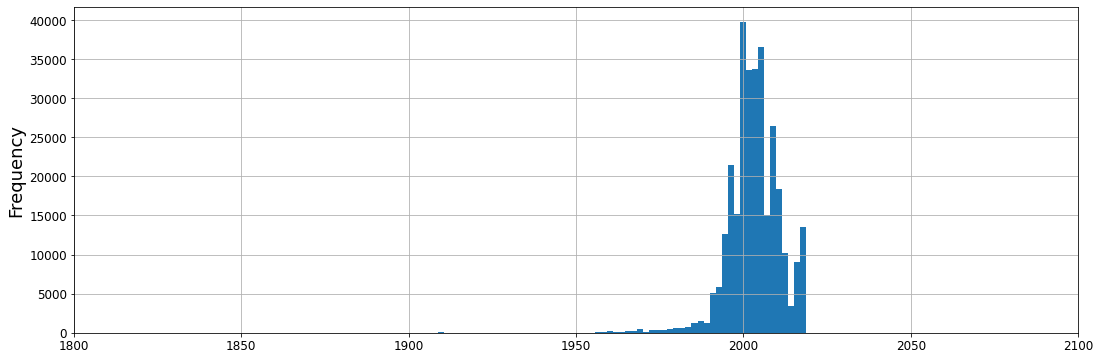

In [17]:
# check
registration_year_pct = data[(data.registration_year>=1900) & (data.registration_year<=2016)].shape[0] / data.shape[0]

print(f'Cоотношение строк с годом регистрации автомобиля из отрезка [1900, 2016]: {round(registration_year_pct * 100, 4)}%')
data.registration_year.plot(kind='hist', grid=True, figsize=(18,6), bins=5000, xlim=(1800, 2100));

Соотношение строк с годом регистрации автомобиля из отрезка $[1900, 2016]$ велико. Оставим только столбцы с годом регистрации автомобиля из этого отрезка

In [18]:
data = data[(data.registration_year >= 1900) & (data.registration_year <= 2016)]

##### Столбец `price`

Соотношение строк с ценой автомобиля меньше 500 евро: 10.3546%


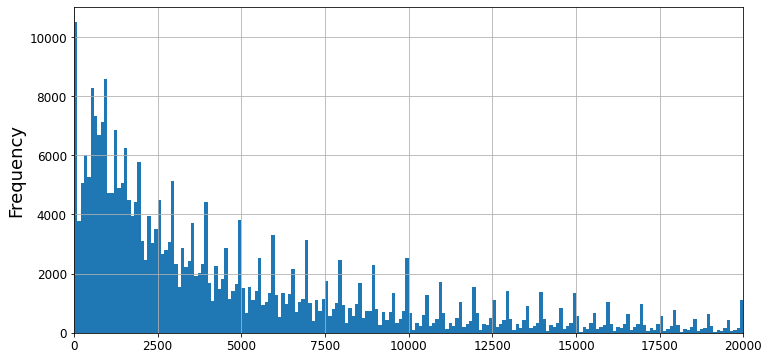

In [19]:
# check
price_pct = data[data.price<500].shape[0] / data.shape[0]

print(f'Соотношение строк с ценой автомобиля меньше 500 евро: {round(price_pct * 100, 4)}%')
data.price.plot(kind='hist', grid=True, figsize=(12,6), bins=200, xlim=(0, 20000));

Оставим только строки с ценой автомобиля $>=500$ евро

In [20]:
data = data[(data.price>=500)]

##### Столбец `power`

Соотношение строк с нулевой мощностью автомобиля: 8.6441%
Соотношение строк с мощностью автомобиля из интервала (0, 50): 1.3178%


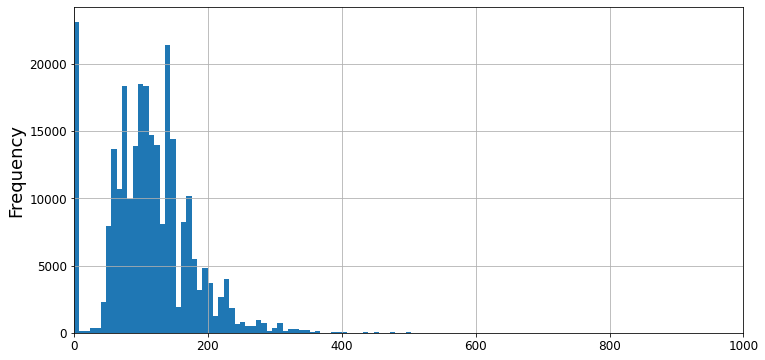

In [21]:
# check
power_zero_pct = data[data.power==0].shape[0] / data.shape[0]
power_low_pct = data[(data.power>0) & (data.power<50)].shape[0] / data.shape[0]

print(f'Соотношение строк с нулевой мощностью автомобиля: {round(power_zero_pct * 100, 4)}%')
print(f'Соотношение строк с мощностью автомобиля из интервала (0, 50): {round(power_low_pct * 100, 4)}%')
data.power.plot(kind='hist', grid=True, figsize=(12,6), bins=2500, xlim=(0, 1000));

Оставим только строки с мощностью автомобиля равной $0$ или $>= 50$ л.с. Соотношение строк с нулевой мощностью автомобиля достаточно велико. Будем считать такие значения неявными пропусками. Так как данных слишком много, откажемся от использования многомерных алгоритмов заполнения пропусков. (например, `IterativeImputer` и `KNNImputer`) Заполним такие пропуски медианным значением при помощи одномерного алгоритма `SimpleImputer`.

In [22]:
data = data[(data.power==0) | (data.power>=50)]

#### Создадим базовый пайплайн с предобработкой данных

Закодируем все категориальные признаки при помощи техники `OneHotEncoding` для того, чтобы в дальнейшем использовать линейные модели. (техника `OrdinalEncoding` плохо сочетается с линейными моделями) Пропуски остануться на месте и будут закодированы особым значением.

In [23]:
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=0, strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, data.columns.difference(['price', 'power'])),
        ('numerical', numeric_transformer, ['power'])
    ]
)

base_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
base_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['brand', 'fuel_type', 'gearbox', 'kilometer', 'model',
       'registration_year', 'repaired', 'vehicle_type'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=0,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['power'])]))])

#### Краткий вывод:
- исправили нарушения правил хорошего стиля в названиях столбцов
- исправили несоответствия типов в столбцах
- удалили неинформативные признаки, которые не несут ценности для прогноза
- очистили данные от дубликатов (были найдены только явные дубликаты)
- очистили данные от аномальных значений в признаках `registration_year` и `price`
- создали базовый пайплайн, в котором будут заполнены неявные пропуски в столбце `power` и закодированы категориальные переменные при помощи техники `OneHotEncoding` на этапе обучения

## Обучение моделей

### Разделим данные на обучающую и тестовую выборки

In [24]:
X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Создание моделей

Будем использовать две модели - `SGDRegressor` и `GradientBoosting`

In [25]:
sgd_regressor_model = Pipeline(steps=[
    ('preprocessor', base_pipeline), 
    ('sgd_regressor', SGDRegressor(random_state=RANDOM_STATE))
])
sgd_regressor_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   Index(['brand', 'fuel_type', 'gearbox', 'kilometer', 'model',
       'registration_year', 'repaired', 'vehicle_type'],
      dtype='object')),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(missing_values=0,
                                                                                                  strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['power'])]))])),
                ('sgd_regressor', SGDRegressor(random_state=751286))])

In [26]:
gradient_boosting_model = Pipeline(steps=[
    ('preprocessor', base_pipeline),
    ('gradient_boosting', LGBMRegressor(random_state=RANDOM_STATE))
])
gradient_boosting_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   Index(['brand', 'fuel_type', 'gearbox', 'kilometer', 'model',
       'registration_year', 'repaired', 'vehicle_type'],
      dtype='object')),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(missing_values=0,
                                                                                                  strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['power'])]))])),
                ('gradient_boosting', LGBMRegressor(random_state=751286))])

### Кросс-валидация

In [27]:
sgd_regressor_cv = RandomizedSearchCV(sgd_regressor_model,
                                      param_distributions={
                                          'sgd_regressor__penalty': ['l2', 'l1', 'elasticnet'],
                                          'sgd_regressor__alpha': [0.001, 0.01, 0.1],
                                          'sgd_regressor__max_iter': [10, 100],
                                          'sgd_regressor__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
                                          'sgd_regressor__eta0': [0.001, 0.01, 0.1]
                                      },
                                      n_iter=100,
                                      n_jobs=-1,
                                      cv=5,
                                      scoring='neg_root_mean_squared_error',
                                      verbose=10).fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 1/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2635013.882 total time=  45.3s
[CV 2/5; 1/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 1/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-16985374.257 total time=  45.6s
[CV 3/5; 1/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 1/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-21067827.973 total time=  52.6s
[CV 4/5; 1/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 1/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-19939101.967 total time=  53.6s
[CV 5/5; 1/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 1/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-44518194.053 total time=  55.2s
[CV 1/5; 2/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 2/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-79131491.587 total time=   8.4s
[CV 2/5; 2/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 2/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-138629219.958 total time=   8.0s
[CV 3/5; 2/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 2/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-55357046.375 total time=   8.0s
[CV 4/5; 2/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 2/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-157166754.541 total time=   8.1s
[CV 5/5; 2/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 2/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-142704010.741 total time=   5.8s
[CV 1/5; 3/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 3/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-45453498.095 total time=   5.9s
[CV 2/5; 3/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 3/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-208115326.578 total time=   6.1s
[CV 3/5; 3/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 3/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-52481030.456 total time=   5.8s
[CV 4/5; 3/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 3/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-86578842.814 total time=   6.0s
[CV 5/5; 3/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 3/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-118607339.820 total time=   6.0s
[CV 1/5; 4/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 4/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-6875.625 total time=   4.2s
[CV 2/5; 4/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 4/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-43164.395 total time=   4.1s
[CV 3/5; 4/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 4/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3667.840 total time=   4.1s
[CV 4/5; 4/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 4/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1613897.116 total time=   4.3s
[CV 5/5; 4/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 4/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1929044.581 total time=   4.1s
[CV 1/5; 5/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 5/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-71860.576 total time=  24.8s
[CV 2/5; 5/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 5/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-76225.378 total time=  24.6s
[CV 3/5; 5/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 5/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-62247.654 total time=  24.9s
[CV 4/5; 5/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 5/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-75435.381 total time=  25.4s
[CV 5/5; 5/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 5/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-23431.219 total time=  25.0s
[CV 1/5; 6/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 6/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3581.935 total time=   6.0s
[CV 2/5; 6/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 6/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3474.137 total time=   6.1s
[CV 3/5; 6/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 6/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-4206.299 total time=   6.0s
[CV 4/5; 6/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 6/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-10364.233 total time=   6.1s
[CV 5/5; 6/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 6/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3415.006 total time=   6.0s
[CV 1/5; 7/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 7/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2436.706 total time=  43.9s
[CV 2/5; 7/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 7/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-3951.544 total time=  44.3s
[CV 3/5; 7/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 7/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2278.479 total time=  43.8s
[CV 4/5; 7/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 7/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2313.784 total time=  44.2s
[CV 5/5; 7/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 7/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2280.344 total time=  43.6s
[CV 1/5; 8/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 8/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-120573.357 total time=  54.5s
[CV 2/5; 8/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 8/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-189459.062 total time= 1.3min
[CV 3/5; 8/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 8/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-213470.914 total time= 1.5min
[CV 4/5; 8/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 8/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-75218.422 total time= 1.6min
[CV 5/5; 8/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 8/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-51264.955 total time= 1.2min
[CV 1/5; 9/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 9/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2385.221 total time=  46.9s
[CV 2/5; 9/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 9/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2385.922 total time=  45.2s
[CV 3/5; 9/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 9/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2360.156 total time=  45.1s
[CV 4/5; 9/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 9/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2363.802 total time=  46.1s
[CV 5/5; 9/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 9/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2377.705 total time=  44.2s
[CV 1/5; 10/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 10/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2351.873 total time=   4.1s
[CV 2/5; 10/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 10/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2356.193 total time=   4.1s
[CV 3/5; 10/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 10/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2334.027 total time=   4.0s
[CV 4/5; 10/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 10/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2341.168 total time=   4.1s
[CV 5/5; 10/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 10/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2352.797 total time=   4.1s
[CV 1/5; 11/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 1/5; 11/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-237737699.279 total time=   6.0s
[CV 2/5; 11/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 2/5; 11/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-4811699365.757 total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 12/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-19695976305.446 total time=   4.0s
[CV 2/5; 12/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 12/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1843875358.440 total time=   4.7s
[CV 3/5; 12/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 12/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-62651389131.724 total time=   8.1s
[CV 4/5; 12/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 4/5; 12/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-47864233427.752 total time=   4.4s
[CV 5/5; 12/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 12/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-8959311064.783 total time=   4.6s
[CV 1/5; 13/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 13/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-31129957858.754 total time= 1.2min
[CV 2/5; 13/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 13/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-46419022403.473 total time= 1.3min
[CV 3/5; 13/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 13/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-93417501098.530 total time= 1.5min
[CV 4/5; 13/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 13/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-103062795011.807 total time= 1.5min
[CV 5/5; 13/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 13/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-46001020189.759 total time=  45.0s
[CV 1/5; 14/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 1/5; 14/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-15021443541.653 total time=  10.5s
[CV 2/5; 14/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 2/5; 14/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-35898908272.309 total time=  13.1s
[CV 3/5; 14/100] STA

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 15/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1907817623.524 total time=   5.9s
[CV 2/5; 15/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 15/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1580225927.966 total time=   6.0s
[CV 3/5; 15/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 15/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-21858714284.469 total time=   5.8s
[CV 4/5; 15/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 15/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-46407548962.979 total time=   6.1s
[CV 5/5; 15/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 15/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-4002389971.718 total time=   5.8s
[CV 1/5; 16/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet
[CV 1/5; 16/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-133422.248 total time=   4.2s
[CV 2/5; 16/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet
[CV 2/5; 16/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-70864.126 total time=   4.3s
[CV 3/

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 16/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-7251.760 total time=   6.0s
[CV 5/5; 16/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet
[CV 5/5; 16/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-6934.783 total time=   5.1s
[CV 1/5; 17/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 17/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-25525079918.831 total time=   6.1s
[CV 2/5; 17/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 17/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-23316900677.734 total time=   5.9s
[CV 3/5; 17/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 17/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-3375696730.198 total time=   6.0s
[CV 4/5; 17/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 17/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-33534628818.851 total time=   6.0s
[CV 5/5; 17/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 17/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-450159801967.694 total time=   6.2s
[CV 1/5; 18/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 1/5; 18/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-13872514643.627 total time=   3.6s
[CV 2/5; 18/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 18/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-6459659316.133 total time=   4.1s
[CV 3/5; 18/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 18/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-61940910264.587 total time=   4.0s
[CV 4/5; 18/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 4/5; 18/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-17968314418.918 total time=   3.2s
[CV 5/5; 18/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 18/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1882108286.778 total time=   4.0s
[CV 1/5; 19/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 1/5; 19/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-1907815177.522 total time=   6.0s
[CV 2/5; 19/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 2/5; 19/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-11668550996.411 total time=   6.4s
[CV 3/5; 19/100] START

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 20/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-58750250.250 total time=   6.1s
[CV 2/5; 20/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 20/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-8442044.159 total time=   6.2s
[CV 3/5; 20/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 20/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-429583.632 total time=   6.0s
[CV 4/5; 20/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 20/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-7331682.667 total time=   6.0s
[CV 5/5; 20/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 20/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-11848643.957 total time=   6.0s
[CV 1/5; 21/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 21/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-5381784302.126 total time=   6.0s
[CV 2/5; 21/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 21/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-6957867444.590 total time=   6.0s
[CV 3/5; 21/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 21/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-62120020366.938 total time=   5.9s
[CV 4/5; 21/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet
[CV 4/5; 21/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-21121933312.835 total time=   4.3s
[CV 5/5; 21/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 21/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2644415378.451 total time=   6.0s
[CV 1/5; 22/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 22/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-3307.847 total time=   4.7s
[CV 2/5; 22/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 22/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-3341.438 total time=   4.8s
[CV 3/5; 22/100] START sgd_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 23/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-16695499.966 total time=  44.1s
[CV 2/5; 23/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 23/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-84921046.625 total time=  46.3s
[CV 3/5; 23/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 23/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-18302372.097 total time=  43.2s
[CV 4/5; 23/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 23/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-33461983.977 total time=  45.8s
[CV 5/5; 23/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 23/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-46745787.083 total time=  46.0s
[CV 1/5; 24/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 24/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-75565238612.711 total time=   6.0s
[CV 2/5; 24/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 24/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-74175666434.569 total time=   6.0s
[CV 3/5; 24/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 24/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-123115211440.080 total time=   6.0s
[CV 4/5; 24/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 24/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-131773568581.610 total time=   6.1s
[CV 5/5; 24/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 24/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-117587983690.456 total time=   6.0s
[CV 1/5; 25/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 25/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-133912469.794 total time=   4.1s
[CV 2/5; 25/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 25/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-1473872947.209 total time=   5.2s
[CV 3/5; 25/100] START sgd_r

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 26/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-100367.465 total time=   4.1s
[CV 2/5; 26/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 26/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-6853.593 total time=   4.2s
[CV 3/5; 26/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 26/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3387.075 total time=   4.1s
[CV 4/5; 26/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 26/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-5393.824 total time=   4.1s
[CV 5/5; 26/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 26/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-25952.218 total time=   4.1s
[CV 1/5; 27/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 27/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-41863.047 total time=  25.1s
[CV 2/5; 27/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 27/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-4096.780 total time=  24.7s
[CV 3/5; 27/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 27/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-3324.279 total time=  24.7s
[CV 4/5; 27/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 27/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-3699.445 total time=  25.0s
[CV 5/5; 27/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 27/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-11124.248 total time=  25.2s
[CV 1/5; 28/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 28/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2369.018 total time=  44.2s
[CV 2/5; 28/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 28/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2368.373 total time=  43.2s
[CV 3/5; 28/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 28/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2343.101 total time=  43.3s
[CV 4/5; 28/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 28/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2346.389 total time=  43.1s
[CV 5/5; 28/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 28/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2360.536 total time=  43.3s
[CV 1/5; 29/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 29/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2623.786 total time=   6.2s
[CV 2/5; 29/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 29/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2637.619 total time=   6.0s
[CV 3/5; 29/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 29/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2609.921 total time=   6.0s
[CV 4/5; 29/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 29/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2615.682 total time=   6.1s
[CV 5/5; 29/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 29/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2633.421 total time=   6.0s
[CV 1/5; 30/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 1/5; 30/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2581.161 total time=  32.9s
[CV 2/5; 30/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 30/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2590.774 total time=  43.6s
[CV 3/5; 30/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 30/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2562.614 total time=  43.5s
[CV 4/5; 30/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 30/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2569.114 total time=  43.2s
[CV 5/5; 30/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 5/5; 30/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2579.482 total time=  34.5s
[CV 1/5; 31/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 31/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-16695499.966 total time=  42.9s
[CV 2/5; 31/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 31/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-84921046.625 total time=  46.1s
[CV 3/5; 31/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 31/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-18302372.097 total time=  42.9s
[CV 4/5; 31/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 31/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-33461983.977 total time=  44.8s
[CV 5/5; 31/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 31/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-46745787.083 total time=  45.0s
[CV 1/5; 32/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 32/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-3313.243 total time=  15.0s
[CV 2/5; 32/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 32/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-3337.765 total time=  19.0s
[CV 3/5; 32/100] START sgd_regressor__a

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 34/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2566.017 total time=   6.0s
[CV 2/5; 34/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 34/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2589.213 total time=   5.9s
[CV 3/5; 34/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 34/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2559.771 total time=   6.2s
[CV 4/5; 34/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 34/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-7251.760 total time=   6.0s
[CV 5/5; 34/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 34/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2633.695 total time=   5.9s
[CV 1/5; 35/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 35/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-4522.057 total time=   4.3s
[CV 2/5; 35/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 35/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-3839.963 total time=   4.2s
[CV 3/5; 35/100] START sgd_regressor__alpha=0

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 38/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-79131491.587 total time=   4.6s
[CV 2/5; 38/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 38/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-138629219.958 total time=   3.9s
[CV 3/5; 38/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 38/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-55357046.375 total time=   4.0s
[CV 4/5; 38/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 38/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-157166754.541 total time=   4.1s
[CV 5/5; 38/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 38/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-142704010.741 total time=   4.0s
[CV 1/5; 39/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 39/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-79131491.587 total time=   4.1s
[CV 2/5; 39/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 39/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-138629219.958 total time=   4.1s
[CV 3/5; 39/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 39/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-55357046.375 total time=   4.0s
[CV 4/5; 39/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 39/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-157166754.541 total time=   4.1s
[CV 5/5; 39/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 39/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-142704010.741 total time=   4.1s
[CV 1/5; 40/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 1/5; 40/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-1144967299.394 total time=   6.1s
[CV 2/5; 40/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 2/5; 40/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-5961361529.386 total time=  

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 41/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1106293731.654 total time=   4.1s
[CV 2/5; 41/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 41/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2146180310.639 total time=   4.1s
[CV 3/5; 41/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 41/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-12090748958.456 total time=   4.0s
[CV 4/5; 41/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 4/5; 41/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2776306561.849 total time=   3.1s
[CV 5/5; 41/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 5/5; 41/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1162531476.809 total time=   3.1s
[CV 1/5; 42/100] START sgd

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 42/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-39156703.695 total time=   4.1s
[CV 2/5; 42/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 42/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-66457564.014 total time=   4.1s
[CV 3/5; 42/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 42/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-74288098.703 total time=   4.1s
[CV 4/5; 42/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 42/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-68086816.943 total time=   4.1s
[CV 5/5; 42/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 42/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-132484637.373 total time=   4.0s
[CV 1/5; 43/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 1/5; 43/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-3249.089 total time=   7.3s
[CV 2/5; 43/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 2/5; 43/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-3280.477 total time=   7.3s
[CV 3

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 45/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-17014339070.293 total time=   4.0s
[CV 2/5; 45/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 45/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-4873923119.221 total time=   4.1s
[CV 3/5; 45/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 45/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1452737355.120 total time=   4.1s
[CV 4/5; 45/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 45/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-339096894313.154 total time=   4.1s
[CV 5/5; 45/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 45/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3457981690.218 total time=   4.0s
[CV 1/5; 46/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 1/5; 46/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-6478.763 total time=  17.0s
[CV 2/5; 46/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 46/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-3174.880 total time=  44.0s
[CV 3/5; 46/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 46/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2268.605 total time=  42.4s
[CV 4/5; 46/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 46/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2264.960 total time=  43.1s
[CV 5/5; 46/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 46/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2275.019 total time=  42.8s
[CV 1/5; 47/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 47/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-45927.402 total time=   5.9s
[CV 2/5; 47/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 47/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-7100.091 total time=   6.0s
[CV 3/5; 47/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 47/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-2470.125 total time=   6.0s
[CV 4/5; 47/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 47/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-6359.007 total time=   5.8s
[CV 5/5; 47/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 47/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-2722.065 total time=   5.7s
[CV 1/5; 48/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 48/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1907815177.522 total time=   5.9s
[CV 2/5; 48/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 48/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-3116673639.862 total time=   5.9s
[CV 3/5; 48/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 48/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-21770247991.619 total time=   6.0s
[CV 4/5; 48/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 48/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-38253167548.181 total time=   6.0s
[CV 5/5; 48/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 48/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-2593603621.008 total time=   6.0s
[CV 1/5; 49/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 49/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-44424516933.353 total time=   6.0s
[CV 2/5; 49/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 49/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-61724506466.204 total time=   5.9s
[CV 3/5; 49/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 49/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-112045127133.392 total time=   6.0s
[CV 4/5; 49/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 49/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-133844223316.052 total time=   6.0s
[CV 5/5; 49/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 49/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-71782758140.094 total time=   5.9s
[CV 1/5; 50/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 1/5; 50/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-136174.463 total time=   3.1s
[CV 2/5; 50/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 2/5; 50/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-72041.022 total time=   3.1s
[CV 3/5; 50/100] START sgd_regressor_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 50/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-7590.925 total time=   4.0s
[CV 5/5; 50/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 5/5; 50/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-6861.266 total time=   3.6s
[CV 1/5; 51/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 51/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2704.207 total time=   6.1s
[CV 2/5; 51/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 51/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2720.762 total time=   6.0s
[CV 3/5; 51/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 51/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2691.919 total time=   5.9s
[CV 4/5; 51/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 51/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2698.963 total time=   6.1s
[CV 5/5; 51/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 51/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2713.309 total time=   6.0s
[CV 1/5; 52/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 52/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-45453498.095 total time=   6.1s
[CV 2/5; 52/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 52/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-208115326.578 total time=   6.1s
[CV 3/5; 52/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 52/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-52481030.456 total time=   5.9s
[CV 4/5; 52/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 52/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-86578842.814 total time=   6.2s
[CV 5/5; 52/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 52/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-118607339.820 total time=   6.0s
[CV 1/5; 53/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 53/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1907815404.680 total time=   6.0s
[CV 2/5; 53/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 53/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1883204060.236 total time=   6.0s
[CV 3/5; 53/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 53/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-21781840509.691 total time=   6.0s
[CV 4/5; 53/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 53/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-58184573630.088 total time=   5.9s
[CV 5/5; 53/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 53/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-3193391684.812 total time=   6.1s
[CV 1/5; 54/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 54/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-9245431359.864 total time=   6.0s
[CV 2/5; 54/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 54/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-4398816723.079 total time=   6.1s
[CV 3/5; 54/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 54/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-56697220086.007 total time=   5.8s
[CV 4/5; 54/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 4/5; 54/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-53354084723.073 total time=   4.4s
[CV 5/5; 54/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 5/5; 54/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-16725561989.762 total time=   4.2s
[CV 1/5; 55/100] START s

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 55/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2580.132 total time=  43.6s
[CV 2/5; 55/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 55/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2590.405 total time=  43.6s
[CV 3/5; 55/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 55/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2561.049 total time=  43.2s
[CV 4/5; 55/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 4/5; 55/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2568.327 total time=  40.9s
[CV 5/5; 55/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 55/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2579.509 total time=  44.3s
[CV 1/5; 56/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 1/5; 56/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2581.597 total time=   7.2s
[CV 2/5; 56/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 2/5; 56/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-2592.933 total time=   9.

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 57/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-6949.189 total time=   6.0s
[CV 2/5; 57/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 57/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-108568.732 total time=   6.2s
[CV 3/5; 57/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 57/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3637.394 total time=   5.9s
[CV 4/5; 57/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 57/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-1673037.031 total time=   6.0s
[CV 5/5; 57/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 57/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-35967.218 total time=   6.0s
[CV 1/5; 58/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 1/5; 58/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-25525079918.831 total time=   6.1s
[CV 2/5; 58/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 2/5; 58/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-23316900677.734 total time=   6.1s
[CV 3/5; 58/100] START sgd_regre

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 59/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-19923371241.365 total time=   6.2s
[CV 2/5; 59/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 59/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-5672520794.692 total time=   6.1s
[CV 3/5; 59/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 59/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-63804122783.667 total time=   6.1s
[CV 4/5; 59/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet
[CV 4/5; 59/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-48141956845.435 total time=   4.5s
[CV 5/5; 59/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 59/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-14832048198.792 total time=   6.0s
[CV 1/5; 60/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 60/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2612.979 total time=   9.4s
[CV 2/5; 60/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 60/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2624.799 total time=  12.1s
[CV 3/5; 60/100] START sg

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 61/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2572.184 total time=   6.0s
[CV 2/5; 61/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 61/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2587.363 total time=   6.0s
[CV 3/5; 61/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 61/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2563.260 total time=   6.1s
[CV 4/5; 61/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 61/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2578.147 total time=   6.1s
[CV 5/5; 61/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 61/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-2591.444 total time=   6.0s
[CV 1/5; 62/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 62/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-109898493.916 total time=  44.2s
[CV 2/5; 62/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 62/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-192224717.238 total time=  43.9s
[CV 3/5; 62/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 62/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-81876471.625 total time=  43.8s
[CV 4/5; 62/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 62/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-93101923.978 total time=  43.6s
[CV 5/5; 62/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 62/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-64276067.969 total time=  43.1s
[CV 1/5; 63/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 63/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-153750.126 total time=   6.2s
[CV 2/5; 63/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 63/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-7947.998 total time=   5.8s
[CV 3/5; 63/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 63/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3391.614 total time=   5.8s
[CV 4/5; 63/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 63/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-8072.191 total time=   6.1s
[CV 5/5; 63/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 63/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-39387.027 total time=   6.2s
[CV 1/5; 64/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 64/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-111098720.010 total time=  44.3s
[CV 2/5; 64/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 64/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-118474112.242 total time=  44.0s
[CV 3/5; 64/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 64/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-85398392.309 total time=  43.3s
[CV 4/5; 64/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 64/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-81819144.234 total time=  44.1s
[CV 5/5; 64/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 64/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-59447762.699 total time=  43.2s
[CV 1/5; 65/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 65/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-25607521845.446 total time=   5.9s
[CV 2/5; 65/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 65/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-22482228183.762 total time=   6.0s
[CV 3/5; 65/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 65/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-14578206803.860 total time=   6.1s
[CV 4/5; 65/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 65/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1367385749757.592 total time=   5.9s
[CV 5/5; 65/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 5/5; 65/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-495138436138.508 total time=   4.7s
[CV 1/5; 66/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 66/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-27859757.808 total time=  24.4s
[CV 2/5; 66/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 66/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-49090812.819 total time=  24.3s
[CV 3/5; 66/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 66/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-19411339.893 total time=  24.7s
[CV 4/5; 66/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 66/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-55678849.221 total time=  24.4s
[CV 5/5; 66/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 66/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-50565108.394 total time=  24.4s
[CV 1/5; 67/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 1/5; 67/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2294.119 total time=  29.5s
[CV 2/5; 67/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 2/5; 67/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2282.411 total time=  29.7s
[CV 3/5; 67/100] START sgd_re

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 68/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-33002556.068 total time=  46.4s
[CV 2/5; 68/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 68/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-24615828.259 total time=  44.0s
[CV 3/5; 68/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 68/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-12788907.433 total time=  43.1s
[CV 4/5; 68/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 68/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-9261510.666 total time=  45.3s
[CV 5/5; 68/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 68/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-41448148.169 total time=  43.5s
[CV 1/5; 69/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 69/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2614.787 total time=   4.8s
[CV 2/5; 69/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 69/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2627.439 total time=   6.1s
[CV 3/5; 69/100] START sgd

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 70/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1907817623.524 total time=   5.9s
[CV 2/5; 70/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 70/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1580225927.966 total time=   6.1s
[CV 3/5; 70/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 70/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-21858714284.469 total time=   5.9s
[CV 4/5; 70/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 4/5; 70/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-5128547205.229 total time=   4.4s
[CV 5/5; 70/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 5/5; 70/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-4554520528.647 total time=   4.3s
[CV 1/5; 71/100] START sgd_regressor

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 71/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-6538.375 total time=   5.9s
[CV 5/5; 71/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 5/5; 71/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-6525.474 total time=   5.1s
[CV 1/5; 72/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 72/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3767.294 total time=   4.2s
[CV 2/5; 72/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 72/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3839.963 total time=   4.1s
[CV 3/5; 72/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 72/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-4359.809 total time=   4.2s
[CV 4/5; 72/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 72/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-11310.177 total time=   4.2s
[CV 5/5; 72/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 5/5; 72/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3735.895 total time=   3.7s
[CV 1/5; 73/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 1/5; 73/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-52462.141 total time=   4.3s
[CV 2/5; 73/100] START sgd_regressor

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 74/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-44424516933.353 total time=   5.9s
[CV 2/5; 74/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 74/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-61724506466.204 total time=   5.9s
[CV 3/5; 74/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 74/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-112045127133.392 total time=   5.9s
[CV 4/5; 74/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 74/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-133844223316.052 total time=   6.1s
[CV 5/5; 74/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 74/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-71782758140.094 total time=   5.9s
[CV 1/5; 75/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 75/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2613.234 total time=  17.7s
[CV 2/5; 75/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 75/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2625.108 total time=  25.1s
[CV 3/5; 75/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 3/5; 75/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2596.299 total time=  21.7s
[CV 4/5; 75/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 4/5; 75/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2599.935 total time=  18.8s
[CV 5/5; 75/100] START sgd_regressor__alpha=0.01, 

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 76/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-17014339070.293 total time=   4.0s
[CV 2/5; 76/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 2/5; 76/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-52226427845.260 total time=   3.6s
[CV 3/5; 76/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 3/5; 76/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-6153001204.615 total time=   3.6s
[CV 4/5; 76/100] START sgd_reg

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 76/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-339096894313.154 total time=   4.1s
[CV 5/5; 76/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 5/5; 76/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-60356966.090 total time=   3.7s
[CV 1/5; 77/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 1/5; 77/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-14508533377.671 total time=  10.2s
[CV 2/5; 77/100] START sgd_re

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 78/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-25659218599.339 total time=   6.1s
[CV 2/5; 78/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 78/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-25167208088.443 total time=   6.0s
[CV 3/5; 78/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 78/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-14373769144.711 total time=   6.0s
[CV 4/5; 78/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 4/5; 78/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-19479083245.591 total time=   5.3s
[CV 5/5; 78/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 5/5; 78/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-494030484447.357 total time=   4.8s
[CV 1/5; 79/100] START sgd_regres

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 79/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2547.486 total time=   4.2s
[CV 2/5; 79/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 79/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-4635.762 total time=   4.0s
[CV 3/5; 79/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 79/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2424.716 total time=   4.0s
[CV 4/5; 79/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 79/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3953.227 total time=   4.0s
[CV 5/5; 79/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 79/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2458.672 total time=   4.1s
[CV 1/5; 80/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 80/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2388.884 total time=  25.1s
[CV 2/5; 80/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 80/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2389.847 total time=  25.2s
[CV 3/5; 80/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 80/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2364.005 total time=  24.8s
[CV 4/5; 80/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 80/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2367.712 total time=  24.7s
[CV 5/5; 80/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 80/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2381.607 total time=  24.8s
[CV 1/5; 81/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 81/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-7910.936 total time=   3.6s
[CV 2/5; 81/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 81/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-3417.828 total time=   4.0s
[CV 3/5; 81/100] START sgd_regressor__alpha=0

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 82/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-105827450.442 total time=   6.0s
[CV 2/5; 82/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 82/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-91532785.882 total time=   5.9s
[CV 3/5; 82/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 82/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-79643155.137 total time=   5.7s
[CV 4/5; 82/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 82/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-82530640.383 total time=   5.9s
[CV 5/5; 82/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 82/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-109890454.479 total time=   5.9s
[CV 1/5; 83/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 83/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-136174.463 total time=   3.2s
[CV 2/5; 83/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 83/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-72041.022 total time=   3.0s
[CV 3/5; 83/100] START sgd_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 84/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2720.267 total time=   4.1s
[CV 2/5; 84/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 84/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2737.282 total time=   4.2s
[CV 3/5; 84/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 84/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2708.235 total time=   4.0s
[CV 4/5; 84/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 84/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2715.468 total time=   4.1s
[CV 5/5; 84/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 84/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2729.278 total time=   4.1s
[CV 1/5; 85/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 1/5; 85/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2296.339 total time=  29.2s
[CV 2/5; 85/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1
[CV 2/5; 85/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-2285.643 total time=  29.0s
[CV 3/5; 85/100] START sgd_regressor__a

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 87/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-133912469.794 total time=   4.0s
[CV 2/5; 87/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 87/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1591666439.147 total time=   4.1s
[CV 3/5; 87/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 87/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3587663794.680 total time=   4.0s
[CV 4/5; 87/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 87/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-60690798845.514 total time=   4.0s
[CV 5/5; 87/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 87/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1142774264.742 total time=   4.0s
[CV 1/5; 88/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 88/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-84837.206 total time=   4.0s
[CV 2/5; 88/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 88/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-6479.268 total time=   4.2s
[CV 3/5; 88/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 3/5; 88/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-5406.192 total time=   3.1s
[CV 4/5; 88/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 4/5; 88/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-3474.733 total time=   3.2s
[CV 5/5; 88/100] START sgd_regressor__alpha=0.1, s

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 89/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-55430259869.503 total time=  43.5s
[CV 2/5; 89/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 89/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-54732111695.547 total time=  43.0s
[CV 3/5; 89/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 89/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-90408946064.885 total time=  42.7s
[CV 4/5; 89/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 89/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-97289378511.442 total time=  44.3s
[CV 5/5; 89/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 89/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-83240864455.777 total time=  43.3s
[CV 1/5; 90/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 90/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-133912469.794 total time=   4.0s
[CV 2/5; 90/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 90/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-1591666439.147 total time=   4.1s
[CV 3/5; 90/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 3/5; 90/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-123676191.363 total time=   3.5s
[CV 4/5; 90/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2
[CV 4/5; 90/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-103889.098 total time=   3.2s
[CV 5/5; 90/100] START sgd_regressor_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 91/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3247.060 total time=   5.9s
[CV 2/5; 91/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 91/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3455.514 total time=   6.6s
[CV 3/5; 91/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 91/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3241.372 total time=   5.9s
[CV 4/5; 91/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 91/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-6394.140 total time=   5.9s
[CV 5/5; 91/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 91/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3241.301 total time=   5.9s
[CV 1/5; 92/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 1/5; 92/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-6875.625 total time=   4.0s
[CV 2/5; 92/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 2/5; 92/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-1816546112.068 total time=   4.3s
[CV 3/5; 92/100] START sgd_regressor

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 93/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1907815177.522 total time=   5.8s
[CV 2/5; 93/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 93/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-3116673639.862 total time=   5.9s
[CV 3/5; 93/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 93/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-21770247991.619 total time=   5.8s
[CV 4/5; 93/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 4/5; 93/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-1576616110.879 total time=   4.3s
[CV 5/5; 93/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 5/5; 93/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-3615682453.780 total time=   4.3s
[CV 1/5; 94/100] START sgd

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 94/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-33002556.068 total time=  46.5s
[CV 2/5; 94/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 94/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-24615828.259 total time=  43.4s
[CV 3/5; 94/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 94/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-12788907.433 total time=  43.1s
[CV 4/5; 94/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 94/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-9261510.666 total time=  45.9s
[CV 5/5; 94/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 94/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-41448148.169 total time=  43.0s
[CV 1/5; 95/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 95/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2335.862 total time=  24.6s
[CV 2/5; 95/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 95/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2335.054 total time=  24.8s
[CV 3/5; 95/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2
[CV 3/5; 95/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2309.153 total time=  19.7s
[CV 4/5; 95/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 95/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2310.599 total time=  25.3s
[CV 5/5; 95/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 95/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=adaptive, sgd_regressor__max_iter=100, sgd_regressor__penalty=l2;, score=-2329.048 total time=  25.1s
[CV 1/5; 96/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 96/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3581.935 total time=   6.2s
[CV 2/5; 96/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet
[CV 2/5; 96/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-4484.555 total time=   5.3s
[CV 3/5; 96/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 96/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-4206.299 total time=   6.3s
[CV 4/5; 96/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 96/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-10364.233 total time=   6.1s
[CV 5/5; 96/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet
[CV 5/5; 96/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=10, sgd_regressor__penalty=elasticnet;, score=-3457.551 total time=   5.2s
[CV 1/5; 97/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 97/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-9941248944.580 total time=   6.2s
[CV 2/5; 97/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 97/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-7289751630.784 total time=   5.9s
[CV 3/5; 97/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 97/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-56386099610.164 total time=   6.0s
[CV 4/5; 97/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 4/5; 97/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-52405941551.417 total time=   4.3s
[CV 5/5; 97/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1
[CV 5/5; 97/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l1;, score=-16881482440.490 total time=   4.3s
[CV 1/5; 98/100] START sgd_re

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 98/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-49230283.278 total time=  43.9s
[CV 2/5; 98/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 98/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-7107039.318 total time=  43.2s
[CV 3/5; 98/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 98/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-358023.488 total time=  43.6s
[CV 4/5; 98/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 98/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-6163130.042 total time=  43.9s
[CV 5/5; 98/100] START sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 98/100] END sgd_regressor__alpha=0.1, sgd_regressor__eta0=0.1, sgd_regressor__learning_rate=optimal, sgd_regressor__max_iter=100, sgd_regressor__penalty=l1;, score=-10010122.002 total time=  43.0s
[CV 1/5; 99/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 1/5; 99/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-50278.099 total time=   4.3s
[CV 2/5; 99/100] START sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet
[CV 2/5; 99/100] END sgd_regressor__alpha=0.001, sgd_regressor__eta0=0.001, sgd_regressor__learning_rate=constant, sgd_regressor__max_iter=100, sgd_regressor__penalty=elasticnet;, score=-1308463.488 total time=   4.3s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 100/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2605.280 total time=   4.1s
[CV 2/5; 100/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 100/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2621.658 total time=   4.1s
[CV 3/5; 100/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 100/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2597.403 total time=   4.1s
[CV 4/5; 100/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 100/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2613.392 total time=   4.0s
[CV 5/5; 100/100] START sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 100/100] END sgd_regressor__alpha=0.01, sgd_regressor__eta0=0.01, sgd_regressor__learning_rate=invscaling, sgd_regressor__max_iter=10, sgd_regressor__penalty=l2;, score=-2626.787 total time=   4.0s


In [28]:
gradient_boosting_cv = GridSearchCV(gradient_boosting_model,
                                    param_grid={
                                        'gradient_boosting__num_leaves': [10, 100, 1000],
                                        'gradient_boosting__learning_rate': [0.001, 0.01, 0.1],
                                        'gradient_boosting__max_depth': [10, 100, 1000],
                                        'gradient_boosting__n_estimators': [10, 100, 1000]
                                    },
                                    n_jobs=-1,
                                    cv=5,
                                    scoring='neg_root_mean_squared_error',
                                    verbose=10).fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5; 1/81] START gradient_boosting__learning_rate=0.001, gradient_boosting__max_depth=10, gradient_boosting__n_estimators=10, gradient_boosting__num_leaves=10
[CV 1/5; 1/81] END gradient_boosting__learning_rate=0.001, gradient_boosting__max_depth=10, gradient_boosting__n_estimators=10, gradient_boosting__num_leaves=10;, score=-4588.391 total time=   4.0s
[CV 2/5; 1/81] START gradient_boosting__learning_rate=0.001, gradient_boosting__max_depth=10, gradient_boosting__n_estimators=10, gradient_boosting__num_leaves=10
[CV 2/5; 1/81] END gradient_boosting__learning_rate=0.001, gradient_boosting__max_depth=10, gradient_boosting__n_estimators=10, gradient_boosting__num_leaves=10;, score=-4616.541 total time=   4.0s
[CV 3/5; 1/81] START gradient_boosting__learning_rate=0.001, gradient_boosting__max_depth=10, gradient_boosting__n_estimators=10, gradient_boosting__num_leaves=10
[CV 3/5; 1/81] END gradient_boosting__learning_rate=0

### Краткий вывод:
- разделили данные на обучающую и тестовую выборки
- создали модели `SGDRegressor` и `GradientBoosting`
- нашли оптимальные наборы гиперпараметров для обеих моделей при помощи кросс-валидации

## Анализ моделей

<a id='model_analysis'></a>

### Анализ результатов кросс-валидации

In [29]:
# Создадим pd.Series, которая будет хранить результаты кросс-валидации наилучшей модели SGDRegressor
sdg_regressor_cv_results = pd.Series(sgd_regressor_cv.best_params_, name='sgd_regressor_cv_results')
sdg_regressor_cv_results['rmse'] = round(-sgd_regressor_cv.best_score_, 4)

# Подсчитаем время обучения наилучшей модели SGDRegressor
start = time()
best_sgd_regressor_model = sgd_regressor_cv.best_estimator_
best_sgd_regressor_model.fit(X_train, y_train)
end = time()
sdg_regressor_cv_results['train_time'] = round(end - start, 4)

# Подсчитаем время предсказания наилучшей модели SGDRegressor
start = time()
sgd_regressor_predictions = best_sgd_regressor_model.predict(X_train)
end = time()
sdg_regressor_cv_results['prediction_time'] = round(end - start, 4)

print('Результаты кросс-валидации наилучшей модели SGDRegressor:')
display(sdg_regressor_cv_results)

Результаты кросс-валидации наилучшей модели SGDRegressor:


sgd_regressor__penalty                  l1
sgd_regressor__max_iter                100
sgd_regressor__learning_rate    invscaling
sgd_regressor__eta0                 0.0100
sgd_regressor__alpha                0.0010
rmse                             2282.6752
train_time                         32.5444
prediction_time                     1.6279
Name: sgd_regressor_cv_results, dtype: object

In [30]:
# Создадим pd.Series, которая будет хранить результаты кросс-валидации наилучшей модели GradientBoosting
gradient_boosting_cv_results = pd.Series(gradient_boosting_cv.best_params_, name='gradient_boosting_cv_results')
gradient_boosting_cv_results['rmse'] = round(-gradient_boosting_cv.best_score_, 4)

# Подсчитаем время обучения наилучшей модели GradientBoosting
start = time()
best_gradient_boosting_model = gradient_boosting_cv.best_estimator_
best_gradient_boosting_model.fit(X_train, y_train)
end = time()
gradient_boosting_cv_results['train_time'] = round(end - start, 4)

# Подсчитаем время предсказания наилучшей модели GradientBoosting
start = time()
gradient_boosting_predictions = best_gradient_boosting_model.predict(X_train)
end = time()
gradient_boosting_cv_results['prediction_time'] = round(end - start, 4)

print('Результаты кросс-валидации наилучшей модели GradientBoosting:')
display(gradient_boosting_cv_results)

Результаты кросс-валидации наилучшей модели GradientBoosting:


gradient_boosting__learning_rate      0.1000
gradient_boosting__max_depth        100.0000
gradient_boosting__n_estimators    1000.0000
gradient_boosting__num_leaves       100.0000
rmse                               1635.2790
train_time                           91.1909
prediction_time                      36.0450
Name: gradient_boosting_cv_results, dtype: float64

### Анализ результатов тестирования

Модель `SGDRegressor` обучается и делает предсказания чуть быстрее, чем модель `GradientBoosting`. Однако `GradientBoosting` показывает лучшие результаты по метрике `RMSE`. Скорость обучения, скорость предсказания и точность прогнозов являются важными критериями при выборе наилучшей модели. Отдадим наибольший вес точности прогнозов и выберем наилучшую по результатам кросс-валидации модель `GradientBoosting` для тестирования

In [31]:
# Создадим pd.Series, которая будет хранить результаты тестирования наилучшей модели GradientBoosting
gradient_boosting_test_results = pd.Series(gradient_boosting_cv.best_params_, name='gradient_boosting_cv_results')
gradient_boosting_test_results['rmse'] = root_mean_squared_error(y_test, best_gradient_boosting_model.predict(X_test))
print('Результаты тестирования наилучшей модели GradientBoosting:')
display(gradient_boosting_test_results)

Результаты тестирования наилучшей модели GradientBoosting:


gradient_boosting__learning_rate      0.1000
gradient_boosting__max_depth        100.0000
gradient_boosting__n_estimators    1000.0000
gradient_boosting__num_leaves       100.0000
rmse                               1634.0867
Name: gradient_boosting_cv_results, dtype: float64

### Краткий вывод:
- модель `SGDRegressor` обучается чуть быстрее, чем модель `GradientBoosting`
- модель `SGDRegressor` делает предсказания чуть быстрее, чем модель `GradientBoosting`
- модель `GradientBoosting` показала намного меньшее значение `RMSE`, чем модель `SGDRegressor`
- На тестовой выборке результаты совпадают с результатами при кросс-валидации. Следовательно модели удалось уловить зависимость и при этом не переобучиться

## Общий вывод
- загрузили данные и провели небольшой разведочный анализ данных
- в данных присутствовали пропуски, дубликаты, аномальные значения и неинформативные признаки, с которыми мы разобрались на этапе предобработки данных
- разделили данные на обучающую и тестовую выборки
- создали модели `SGDRegressor` и `GradientBoosting`
- нашли оптимальные наборы гиперпараметров для обеих моделей при помощи кросс-валидации
- модель `SGDRegressor` обучается чуть быстрее, чем модель `GradientBoosting`
- модель `SGDRegressor` делает предсказания чуть быстрее, чем модель `GradientBoosting`
- модель `GradientBoosting` показала намного меньшее значение `RMSE`, чем модель `SGDRegressor`
- На тестовой выборке результаты совпадают с результатами при кросс-валидации. Следовательно модели удалось уловить зависимость и при этом не переобучиться
- для оптимизации скорости обучения и предсказания рекомендуется использовать модель `SGDRegressor`. Во всех остальных случаях лучше всего подойдёт модель `GradientBoosting`